# Validation Monte Carlo PET

In [1]:
from __future__ import annotations
import numpy as np
import torch
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta, PETTOFMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate
import numpy as np
import nibabel as nib
import numpy.linalg as npl
from scipy.ndimage import affine_transform
import os
from scipy.ndimage import binary_erosion
import matplotlib.pyplot as plt
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.io.shared import get_attenuation_map_interfile
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Recon

In [2]:
input_path = '/disk1/pytomography_paper_data/input'
output_path = '/disk1/pytomography_paper_data/output'

In [3]:
# Determine TOF bin edges for binning 
speed_of_light = 0.3 #mm/ps
fwhm_tof_resolution = 550 * speed_of_light / 2 #ps to position along LOR
TOF_range = 2 * 348 
num_tof_bins = 125
tof_meta = PETTOFMeta(num_tof_bins, TOF_range, fwhm_tof_resolution, n_sigmas=3)

info = gate.get_detector_info(path = os.path.join(input_path, 'pet_gate_experiment', 'mMR_Geometry.mac'), mean_interaction_depth=9)
# Get detector IDs from GATE file
path = '/disk1/pet_mri_scan/'
paths = [os.path.join(path, f'gate_simulation/no_atten/f{i}.root') for i in range(1, 19)]
macro_path = os.path.join(path, 'mMR_Geometry.mac')
detector_ids = gate.get_detector_ids_from_root(
    paths,
    info,
    include_randoms=False, 
    tof_meta=tof_meta)
torch.save(detector_ids, os.path.join(input_path, 'pet_gate_validation', 'detector_ids_tof_all_events.pt'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

In [4]:
norm_factor = torch.load(os.path.join(input_path, 'pet_gate_experiment', 'detector_ids', 'norm_factor_lm.pt'))
detector_ids = torch.load(os.path.join(input_path, 'pet_gate_validation', 'detector_ids_tof_all_events.pt'))

In [42]:
info = gate.get_detector_info(path = os.path.join(input_path, 'pet_gate_experiment', 'mMR_Geometry.mac'), mean_interaction_depth=10) # Gate default: crystal_size / 2

In [43]:
object_meta = ObjectMeta(
    dr=(1.675,1.675,2.0315), #mm
    shape=(146,146,127) #voxels
)

In [44]:
# THESE WERE THE PARAMETERS USED FOR SAVING THE TOF
speed_of_light = 0.3 #mm/ps
fwhm_tof_resolution = 550 * speed_of_light / 2 #ps to position along LOR
TOF_range = 2 * 2 * 348 
num_tof_bins = 125
tof_meta = PETTOFMeta(num_tof_bins, TOF_range, fwhm_tof_resolution, n_sigmas=3)

In [45]:
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    tof_meta=tof_meta,
    weights_sensitivity=norm_factor
    )

In [46]:
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [],
    N_splits=8,
)
likelihood = PoissonLogLikelihood(system_matrix)
recon_algorithm = OSEM(likelihood)
recon = recon_algorithm(n_iters=2, n_subsets=21)

CASTOR Recon

In [47]:
castor_recon = get_attenuation_map_interfile('/disk1/pet_mri_scan/castor_recon/Image_LM_TOF_Prompts_NCFs_noACFs_voxBrain_mMR_it2.hdr')[99:-99,99:-99].flip(dims=[1]) # flip y axis for castor

In [48]:
recon = recon * castor_recon.sum() / recon.sum()

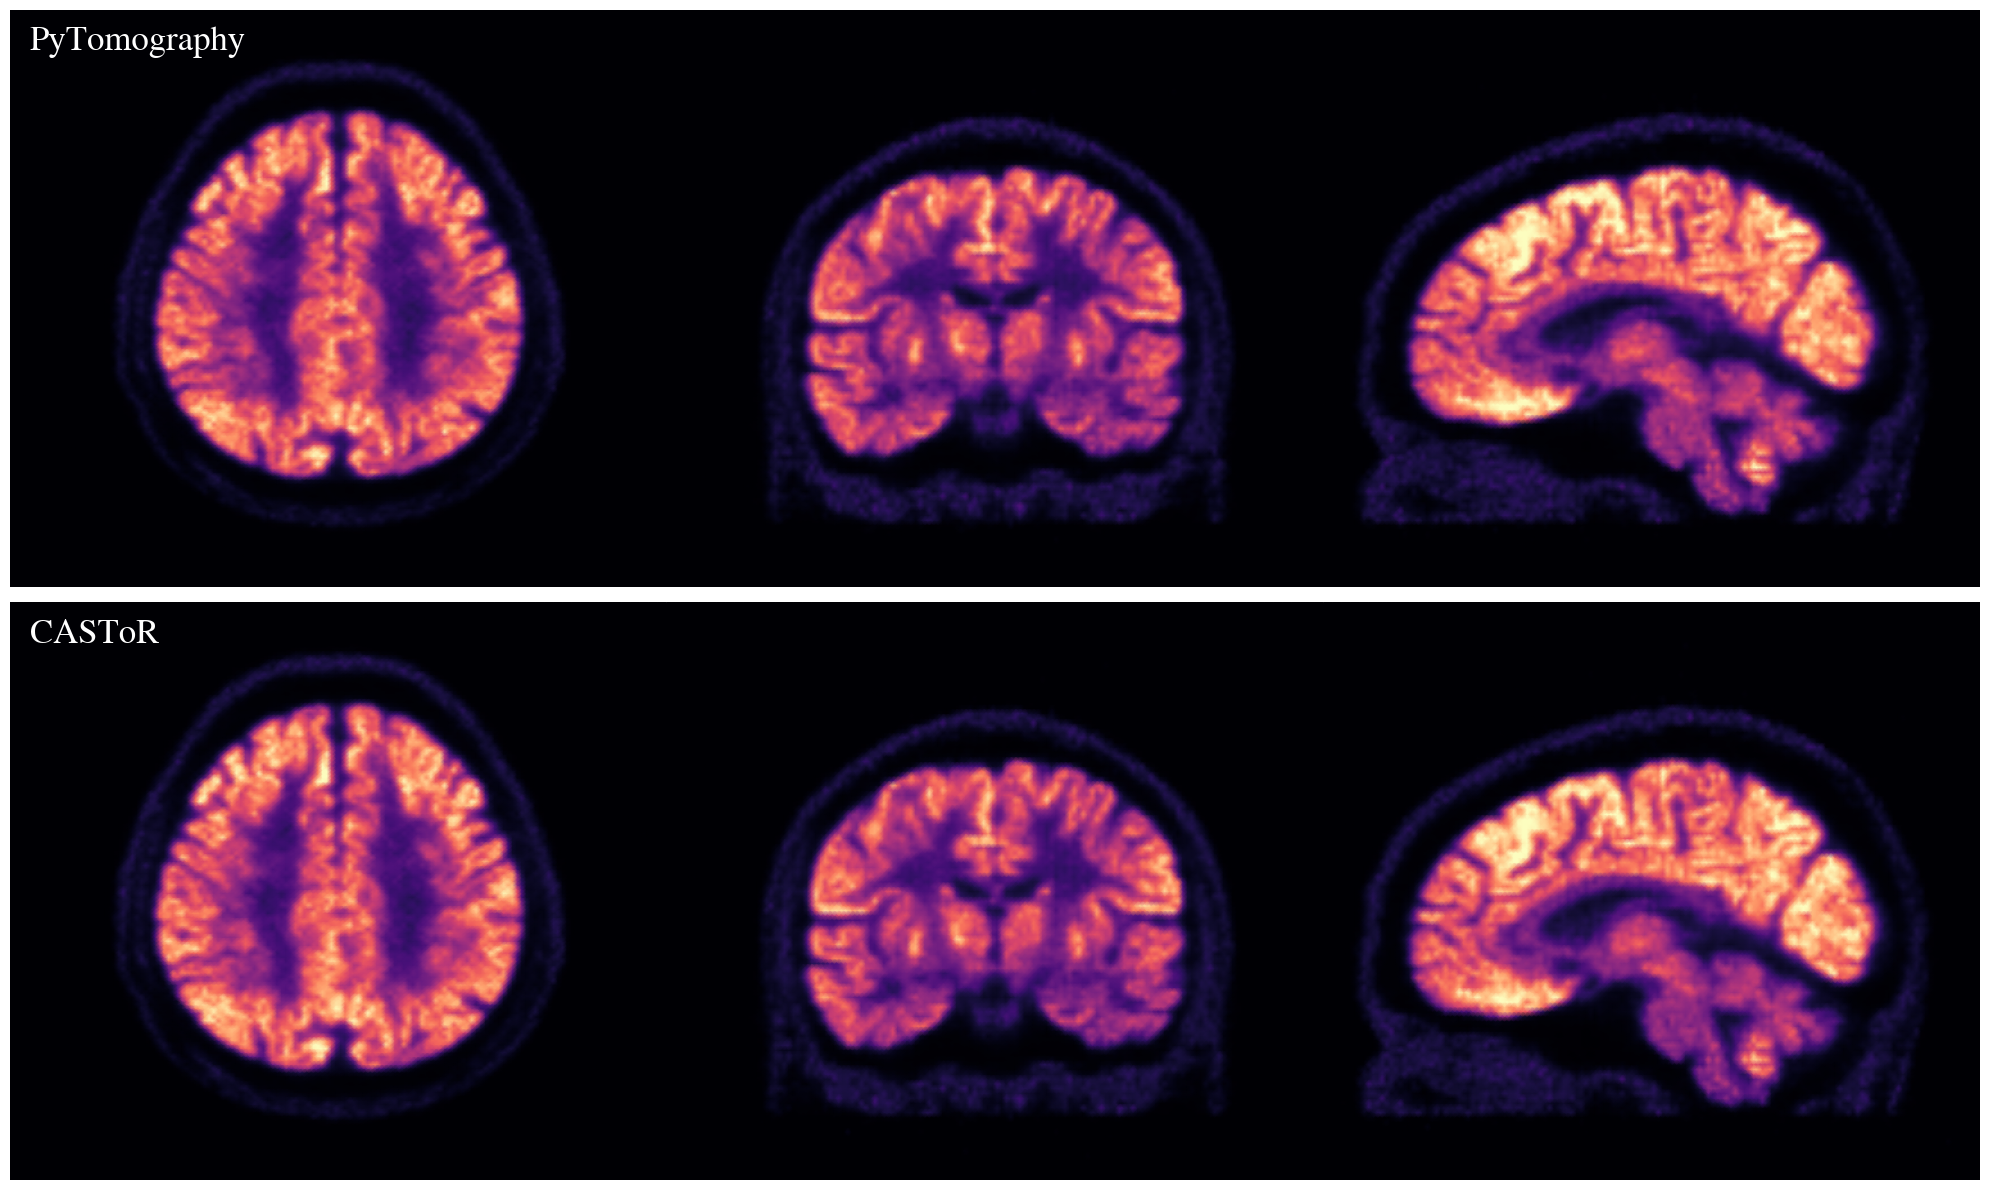

In [49]:
slc = 70
ww = 3
vmax = 50000
cmap = 'magma'
fig, ax = plt.subplots(2,3,figsize=(20,12), gridspec_kw=dict(wspace=0.0))
plt.subplot(231)
plt.pcolormesh(recon[:,:,slc].cpu().flip(dims=[-1]).T, cmap=cmap, shading='gouraud', vmax=vmax)
plt.text(0.03,0.93,'PyTomography', fontsize=25, color='white', transform = ax[0][0].transAxes)
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon[:,slc,ww:-ww].cpu().T, cmap=cmap, shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon[slc,:,ww:-ww].cpu().T, cmap=cmap, shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(castor_recon[:,:,slc].cpu().flip(dims=[-1]).T, cmap=cmap, shading='gouraud', vmax=vmax)
plt.text(0.03,0.93,'CASToR', fontsize=25, color='white', transform = ax[1][0].transAxes)
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(castor_recon[:,slc,ww:-ww].cpu().T, cmap=cmap, shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(236)
plt.pcolormesh(castor_recon[slc,:,ww:-ww].cpu().T, cmap=cmap, shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.savefig('norm_TOF.jpg', dpi=300, bbox_inches='tight')

In [52]:
z_slc1, z_slc2 = 54, 76
y_slc = 60
xmin, xmax = 0, -1
ymin, ymax = 0, -1

def plot_differences(ax, y_slc, z_slc, uppery=None, lowery=None):
    distance = np.arange(146)*1.675
    line1 = castor_recon.cpu()[:,y_slc,z_slc].numpy()
    line2 = recon.cpu()[:,y_slc,z_slc].numpy()
    line3 = line1 - line2
    ax.plot(distance, line1, marker='', ls='-', lw=1.5, color='red', label='CASToR')
    ax.plot(distance, line2, marker='', ls='--', lw=1.5, color='blue', label='PyTomography')
    ax.plot(distance, line3, marker='', ls='-', lw=1.5, color='k', label='Difference', zorder=-1000)
    ax.grid()
    if uppery: ax.set_ylim(top=uppery)
    if lowery: ax.set_ylim(bottom=lowery)

def plot_object(ob, ax, add_text=False, mode='color'):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = None
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 20
    im = ax.pcolormesh(ob[:,y_slc,:].T, cmap=cmap, vmax=vmax)
    ax.axhline(z_slc1, ls='--', color=tcol, lw=0.8)
    ax.axhline(z_slc2, ls='--', color=tcol, lw=0.8)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if add_text:
        ax.text(5, z_slc1+3, '1', ha='center', va='center', color=tcol, size=13)
        ax.text(5, z_slc2+3, '2', ha='center', va='center', color=tcol, size=13)
    return im

In [1]:
mode = 'color'
fig = plt.figure(constrained_layout=True, figsize=(8,7))
(subfig_l, subfig_r) = fig.subfigures(nrows=2, ncols=1, height_ratios=(1,0.7))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].set_title('CASToR')
axes_l[1].set_title('PyTomography')
im = plot_object(castor_recon.cpu(), axes_l[0], add_text=True, mode=mode)
im = plot_object(recon.cpu(), axes_l[1], mode=mode)
axes_r = subfig_r.subplots(nrows=1, ncols=2, sharex=True)
plot_differences(axes_r[0],y_slc,z_slc1)
axes_r[0].set_title('Profile 1')
plot_differences(axes_r[1],y_slc,z_slc2)
axes_r[0].set_ylim(top=60000)
axes_r[0].legend(loc='upper left', facecolor='white', framealpha=1, frameon=True, fontsize=10, ncol=2)
axes_r[1].set_title('Profile 2')
subfig_r.supxlabel('Position [mm]')
subfig_r.supylabel('Counts')
plt.savefig('figures/figure7.jpg', dpi=300, bbox_inches='tight')

NameError: name 'plt' is not defined

Compute statistics from white.grey matter

In [30]:
P = lambda: None
P.dr = (1.675,1.675,2.0315)
P.shape = (146,146,127)
P.GREY_MATTER_LOWER = 0.6
P.GREY_MATTER_UPPER = np.inf
P.WHITE_MATTER_LOWER = 0.15
P.WHITE_MATTER_UPPER = 0.4
P.ALIGNMENT_OVERLAP = 0.8
P.PET_PHANTOM_PATH = '/disk1/pet_mri_scan/fdg_pet_phantom_uptake.nii.gz'

In [31]:
def align_highres_image(path, img=None):
    # If img is none, extract data from path
    data = nib.load(path)
    # If img is none, extract data from path
    if img is None:
        img = data.get_fdata()
    Sx, Sy, Sz = -(np.array(img.shape)-1) / 2
    dx, dy, dz = data.header['pixdim'][1:4]
    # Convert from RAS to LPS space for DICOM
    dx*=-1; dy*=-1
    M_highres = np.zeros((4,4))
    M_highres[0] = np.array([dx, 0, 0, Sx*dx])
    M_highres[1] = np.array([0, dy, 0, Sy*dy])
    M_highres[2] = np.array([0, 0, dz, Sz*dz])
    M_highres[3] = np.array([0, 0, 0, 1])
    dx, dy, dz = P.dr
    Sx, Sy, Sz = -(np.array(P.shape)-1) / 2
    M_pet = np.zeros((4,4))
    M_pet[0] = np.array([dx, 0, 0, Sx*dx])
    M_pet[1] = np.array([0, dy, 0, Sy*dy])
    M_pet[2] = np.array([0, 0, dz, Sz*dz])
    M_pet[3] = np.array([0, 0, 0, 1])
    M = npl.inv(M_highres) @ M_pet
    return affine_transform(img, M, output_shape=P.shape, mode='constant', order=1)

def get_masks():
    pet_data = nib.load(P.PET_PHANTOM_PATH)
    pet_highres = pet_data.get_fdata()
    mask_greymatter = (pet_highres<P.GREY_MATTER_UPPER)*(pet_highres>P.GREY_MATTER_LOWER)
    mask_whitematter = (pet_highres<P.WHITE_MATTER_UPPER)*(pet_highres>P.WHITE_MATTER_LOWER)
    mask_whitematter = binary_erosion(mask_whitematter, iterations=1)
    mask_greymatter = binary_erosion(mask_greymatter, iterations=1)
    grey_matter_mask_aligned = align_highres_image(P.PET_PHANTOM_PATH, mask_greymatter.astype(float))>P.ALIGNMENT_OVERLAP
    white_matter_mask_aligned = align_highres_image(P.PET_PHANTOM_PATH, mask_whitematter.astype(float))>P.ALIGNMENT_OVERLAP
    return grey_matter_mask_aligned, white_matter_mask_aligned

def compute_CRC(img, pet_aligned, mask_greymatter, mask_whitematter):
    ar = img[mask_greymatter].mean()
    br = img[mask_whitematter].mean()
    atrue = pet_aligned[mask_greymatter].mean()
    btrue = pet_aligned[mask_whitematter].mean()
    return (ar/br-1)/(atrue/btrue-1)

def compute_mse(img, pet_aligned, mask):
    ratio = pet_aligned.sum() / img.sum()
    true_mean = pet_aligned[mask].mean()
    bias = (ratio*img - pet_aligned)[mask].mean()
    std = (ratio*img - pet_aligned)[mask].std()
    return bias/true_mean, std/true_mean

In [32]:
grey_matter, white_matter = get_masks()

In [34]:
recon.cpu().numpy()[grey_matter].mean() / recon.cpu().numpy()[white_matter].mean()

2.0444329

In [37]:
castor_recon.cpu().numpy()[grey_matter].mean() / castor_recon.cpu().numpy()[white_matter].mean()

2.02912

In [35]:
recon.cpu().numpy()[white_matter].std() / recon.cpu().numpy()[white_matter].mean()

0.32569268

In [36]:
castor_recon.cpu().numpy()[white_matter].std() / castor_recon.cpu().numpy()[white_matter].mean()

0.32177743